---
title: EM算法详解和numpy代码实现
date: 2018-09-13 8:17:55
tags: [python, EM]
toc: true
xiongzhang: true

---
<span></span>
<!-- more -->

> 声明: 本文由[DataScience](http://mlln.cn)原创发表, 转载请注明[本文链接](http://mlln.cn)mlln.cn, 并在文后留言`转载`.

本文代码运行环境:

- windows10
- python3.6
- jupyter notebook


### 用到的资源和基本配置

在教程开始之前了解一下我们将用到的工具, 可以让你们评估一下教程的难度, 并且了解教程的大概内容。我们的教程和本站的大部分内容类似, 都运行在jupyter notebook中, 并且在后续可能会增加在线运行代码的功能。

In [17]:
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd


### 问题介绍

这个例子来自书 Computer Age Statistical Inference By Efron和Hastie。假设我们的数据采自正太双变量:

<img src="images/bi-variate-normal.png" />

用代码来说明就是这样:

In [5]:
# 标准差
sig1=1
sig2=0.75
# 均值
mu1=1.85
mu2=1
rho=0.82
# 均值
means=np.array([mu1, mu2])
#协方差矩阵
cov = np.array([
    [sig1**2, sig1*sig2*rho],
    [sig2*sig1*rho, sig2**2]
])
print('均值:', means)
print('协方差矩阵:', cov)

均值: [1.85 1.  ]
协方差矩阵: [[1.     0.615 ]
 [0.615  0.5625]]


生成我们用到的样本, 第一列表示x, 第二列表示y

In [7]:
samples=np.random.multivariate_normal(means, cov, size=40)
samples

array([[ 2.68359748,  1.48379834],
       [ 1.17791924,  1.38894689],
       [ 1.86489988,  0.64818678],
       [ 3.46263848,  2.52003738],
       [ 3.28320055,  2.09838814],
       [ 2.2243539 ,  0.68423906],
       [-0.81846598,  0.25206792],
       [ 2.8875052 ,  1.21514733],
       [ 2.8089101 ,  2.66763322],
       [-0.43096351, -0.40946548],
       [ 1.59169105,  0.83110871],
       [ 2.33259334,  0.74321063],
       [ 1.23234749,  0.10636416],
       [ 2.77710826,  1.22676301],
       [ 2.30041259,  1.26537629],
       [ 1.46274197,  0.86375528],
       [ 2.34134553,  0.60329965],
       [ 1.41575413,  0.12814199],
       [ 2.89978014,  1.662521  ],
       [ 1.94268688,  0.96135903],
       [ 1.8706036 ,  0.23341228],
       [-0.95437589, -1.59097527],
       [ 2.31569597,  1.16615578],
       [ 2.22949385,  1.51688792],
       [ 1.20585795,  0.65294385],
       [ 1.35490525,  1.49116327],
       [ 0.65720096, -0.04390794],
       [ 3.50395539,  0.94368355],
       [ 2.87762334,

不幸的是, 有些数据是缺失的, 所以我们伪造一些缺失数据, 用0表示缺失, 设置后20行数据的y都为0

In [8]:
samples_censored=np.copy(samples)
samples_censored[20:,1]=0

我们将上面的样本绘制成蓝色点。现在我们丢失了最后20个数据的y值。我们留下了丢失的数据或隐藏数据或潜在变量。

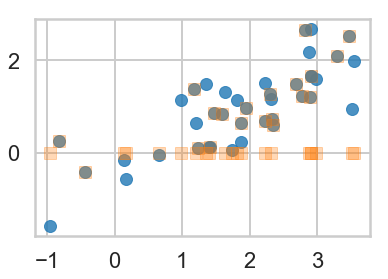

In [9]:
plt.plot(samples[:,0], samples[:,1], 'o', alpha=0.8)
plt.plot(samples_censored[:,0], samples_censored[:,1], 's', alpha=0.3)

如果我们已知所有的数据, 数据没有缺失, 我们可以使用MLE(极大似然估计)的方法求得下面所有的统计量, 下面的公式就是基于MLE推倒而得:

<img src="images/mle.png" />

我们假设缺失值已知, 可以计算得到这些统计量, 这个过程就叫做M-step。下面先写出计算的公式:

In [10]:
mu1 = lambda s: np.mean(s[:,0])
mu2 = lambda s: np.mean(s[:,1])
s1 = lambda s: np.std(s[:,0])
s2 = lambda s: np.std(s[:,1])
rho = lambda s: np.mean((s[:,0] - mu1(s))*(s[:,1] - mu2(s)))/(s1(s)*s2(s))

但是我们缺少y的部分数据,暂时用0来代替缺失值, 使用这个缺失值, 我们可以计算得到上面所有的统计量,  我们应该用迭代的方式找出缺失值的更好的替代值。下这些列表用于存放中间数据:

In [11]:
mu1s=[]
mu2s=[]
s1s=[]
s2s=[]
# 相关系数, 后面有用到
rhos=[]

先使用缺失值0计算所有的统计量:

In [12]:
mu1s.append(mu1(samples_censored))
mu2s.append(mu2(samples_censored))
s1s.append(s1(samples_censored))
s2s.append(s2(samples_censored))
rhos.append(rho(samples_censored))
mu1s,mu2s,s1s,s2s,rhos

([1.8674222131186482],
 [0.5235219836257345],
 [1.1279568484950988],
 [0.7551359797772168],
 [0.43680179723920937])

有了这些参数, 我们可以反过来想, 那些缺失的y是不是可以被估计出来, 一种思路是用平均值代替缺失的y, 也就是下面的公式, 它指的是条件期望,也就是已知x和参数$\theta$的情况下, 去估计y的期望:

$$
E_{p(z \vert \theta, x)}[z]
$$

公式中的$z$表示缺失的y, 用代码表示就是:

条件期望的公式就是:

$$
\bar{y}(t+1) - \hat{\mu_2}(t) = \hat{\rho}(t)\frac{\hat{\sigma_2}(t)}{\hat{\sigma_1}(t)} \left( \bar{x} - \hat{\mu_1}(t) \right)
$$

因为我们的目的是讲解EM算法, 所以条件期望的公式就不详解了, 有兴趣的话看一下wiki的推倒:https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Conditional_distributions

In [16]:

# 用代码实现上面的公式就是:
def ynew(x, mu1, mu2, s1, s2, rho):
    return mu2 + rho*(s2/s1)*(x - mu1)

# 注意计算y的时候, 只使用了缺失值对应的x
newys=ynew(samples_censored[20:,0], mu1s[0], mu2s[0], s1s[0], s2s[0], rhos[0])
newys

array([ 0.52445231, -0.30164726,  0.65460922,  0.62940142,  0.3300629 ,
        0.37364831,  0.16962092,  1.00208806,  0.81893182,  0.48330706,
        0.50814036,  0.82576169,  0.02733923,  1.01448779,  0.01891612,
        0.453238  ,  0.26536647,  0.82550657,  0.38750904,  0.84805622])

上面的这个过程就叫做E-step, 因为我们计算了期望, 下面我们迭代一下看是否能收敛:

In [15]:
for step in range(1,20):
    samples_censored[20:,1] = newys
    #M-step
    mu1s.append(mu1(samples_censored))
    mu2s.append(mu2(samples_censored))
    s1s.append(s1(samples_censored))
    s2s.append(s2(samples_censored))
    rhos.append(rho(samples_censored))
    #E-step
    newys=ynew(samples_censored[20:,0], mu1s[step], mu2s[step], s1s[step], s2s[step], rhos[step])
df=pd.DataFrame.from_dict(dict(mu1=mu1s, mu2=mu2s, s1=s1s, s2=s2s, rho=rhos))
df

,mu1,mu2,s1,s2,rho
0,1.867422,0.523522,1.127957,0.755136,0.436802
1,1.867422,0.769992,1.127957,0.656320,0.734940
2,1.867422,0.886157,1.127957,0.667636,0.827798
3,1.867422,0.940980,1.127957,0.685415,0.853448
4,1.867422,0.966894,1.127957,0.696062,0.861611
5,1.867422,0.979166,1.127957,0.701419,0.864603
6,1.867422,0.984991,1.127957,0.703944,0.865806
7,1.867422,0.987763,1.127957,0.705095,0.866312
8,1.867422,0.989086,1.127957,0.705607,0.866529
9,1.867422,0.989720,1.127957,0.705830,0.866621


我们可以看到, 估计得到的mu2和s2跟初始值(1, 0.75)相比有些出入, 不过也差不多, 因为EM算法只能找到局部最小值, 而不能得到全局最小值。